This notebook presents all the analysis reported in Study 9 of the paper.

Click the "Show Code" buttons to see the code associated with each output.

# Preamble

## Libraries

In [1]:
# Misc
import warnings

warnings.filterwarnings("ignore")
from IPython.display import Markdown


# Data libraries
import pandas as pd
import numpy as np

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

sns.set_context("notebook")

# Statistics
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats.mstats import zscore

# Interface with R
import rpy2

%load_ext rpy2.ipython


%R library(sjstats); # For effect sizes of ANOVAs

STUDY_NAME = "Study 9"

## Functions

In [2]:
# fmt: off
ARRAYS ={
    'Low-Low': [8, 10, 10, 10, 10, 10, 10, 12, 12, 12, 12, 12, 12, 
                12, 12, 12, 12, 12, 12, 14, 14, 14, 14, 14, 14, 16,
                34, 36, 36, 36, 36, 36, 36, 38, 38, 38, 38, 38, 38, 
                38, 38, 38, 38, 38, 38, 40, 40, 40, 40, 40, 40, 42],
    'Low-High': [8, 10, 10, 10, 10, 10, 10, 12, 12, 12, 12, 12, 12, 
                 12, 12, 12, 12, 12, 12, 14, 14, 14, 14, 14, 14, 16,
                 28, 30, 30, 32, 32, 34, 34, 34, 36, 36, 36, 38, 38, 
                 38, 38, 40, 40, 40, 42, 42, 42, 44, 44, 46, 46, 48],
    'High-Low': [2, 4, 4, 6, 6, 8, 8, 8, 10, 10, 10, 12, 12, 12, 
                 12, 14, 14, 14, 16, 16, 16, 18, 18, 20, 20, 22, 
                 34, 36, 36, 36, 36, 36, 36, 38, 38, 38, 38, 38, 38, 
                 38, 38, 38, 38, 38, 38, 40, 40, 40, 40, 40, 40, 42],
    'High-High': [2, 4, 4, 6, 6, 8, 8, 8, 10, 10, 10, 12, 12, 12, 
                  12, 14, 14, 14, 16, 16, 16, 18, 18, 20, 20, 22, 
                  28, 30, 30, 32, 32, 34, 34, 34, 36, 36, 36, 38, 38, 
                  38, 38, 40, 40, 40, 42, 42, 42, 44, 44, 46, 46, 48]
}
# fmt: on


def perc_formatter(x, y, prec=2):
    return "{:.{prec}f}%".format(x, prec=prec)


def is_phantom_values_total(x):
    i = x.value
    if x.mean_focal == 12:
        if x.sd_focal == "Low":
            return ((i < 8) | ((i > 16) & (i < 28))) * 1
        else:
            return ((i < 2) | ((i > 22) & (i < 28))) * 1
    else:
        if x.sd_focal == "Low":
            return ((i > 42) | ((i > 22) & (i < 34))) * 1
        else:
            return ((i > 48) | ((i > 22) & (i < 28))) * 1


def is_phantom_values_outside(x):
    i = x.value
    if x.mean_focal == 12:
        if x.sd_focal == "Low":
            return (i < 8) * 1
        else:
            return (i < 2) * 1
    else:
        if x.sd_focal == "Low":
            return (i > 42) * 1
        else:
            return (i > 48) * 1


def plot_design(
    save=False, show=True, grayscale=False, figname=f"Fig 16 - {STUDY_NAME} - Design"
):
    if grayscale:
        pal = sns.color_palette("Greys")[1::2][::-1]
        pathname = "Grayscale"
    else:
        pal = sns.color_palette()[1:4:2][::-1]
        pathname = "Color"

    if show:
        sns.set_context("notebook")
    else:
        sns.set_context("paper")

    sns.set_style("ticks")

    fig, axes = plt.subplots(2, 2, figsize=(6.38, 4))
    ax1, ax2, ax3, ax4 = axes.flatten()
    phantoms_left = [[0, 8], [0, 8], [0, 2], [0, 2]]
    phantoms_right = [[42, 50], [48, 50], [42, 50], [48, 50]]
    for ax, vartype, pl, pr in zip(
        axes.flatten(),
        ["Low-Low", "Low-High", "High-Low", "High-High"],
        phantoms_left,
        phantoms_right,
    ):
        ax.hist(
            ARRAYS[vartype][0:26],
            label="White Wines",
            color=pal[1],
            bins=np.arange(0, 51, 2),
            align="left",
        )
        ax.hist(
            ARRAYS[vartype][26:],
            label="Red Wines",
            color=pal[0],
            bins=np.arange(0, 51, 2),
            align="left",
        )
        ax.set_yticks([])
        ax.set_ylim(0, 14)
        ax.set_xticks(np.arange(0, 52, 8))
        ax.set_xticklabels([f"${i}" if i % 8 == 0 else "" for i in np.arange(0, 52, 8)])
        ax.set_xlim(-2, 52)

    ax2.legend(frameon=False)

    for ax, col in zip([ax1, ax2], ["Low", "High"]):
        ax.set_title(col + " SD Red Wines")

    for ax, row in zip([ax1, ax3], ["Low", "High"]):
        ax.set_ylabel(row + " SD\nWhite Wines", rotation=90, labelpad=5)

    sns.despine()
    plt.tight_layout()
    if save:
        plt.savefig(
            f"../Figures/{pathname}/{figname}.png", dpi=100, bbox_inches="tight"
        )
    if show:
        plt.show()
    else:
        plt.close()


def plot_phantom_range(
    save=False,
    show=True,
    grayscale=False,
    figname=f"Fig 15 - {STUDY_NAME} - Phantom Values Viz",
):

    if grayscale:
        pal = sns.color_palette("Greys")[1::2][::-1]
        pathname = "Grayscale"
    else:
        pal = sns.color_palette()[1:4:2][::-1]
        pathname = "Color"

    if show:
        sns.set_context("notebook")
    else:
        sns.set_context("paper")

    sns.set_style("ticks")

    fig, axes = plt.subplots(2, figsize=(6.38, 6))

    pl = [0, 8]
    pr = [18, 28]
    ax1, ax2 = axes.flatten()
    ax1.hist(
        ARRAYS["Low-Low"][0:26], color=pal[1], bins=np.arange(0, 51, 2), align="left"
    )
    ax1.hist(
        ARRAYS["Low-Low"][26:],
        color=pal[0],
        bins=np.arange(0, 51, 2),
        align="left",
        histtype="step",
        lw=2,
    )
    ax1.hist(
        ARRAYS["High-High"][26:],
        color=pal[0],
        bins=np.arange(0, 51, 2),
        align="left",
        histtype="step",
        lw=2,
    )
    ax1.bar(
        pr[0] - 1,
        2,
        (pr[1] - pr[0]) - 0.15,
        color="lightgrey",
        ecolor="grey",
        hatch="//",
        align="edge",
        linewidth=1,
    )
    ax1.bar(
        pl[0] - 1,
        2,
        (pl[1] - pl[0]),
        color="lightgrey",
        ecolor="grey",
        hatch="\\",
        align="edge",
        linewidth=1,
    )
    ax1.set_title("Low SD White Wines")

    pl = [0, 2]
    pr = [24, 28]
    ax2.hist(
        ARRAYS["High-Low"][0:26],
        label="White Wines",
        color=pal[1],
        bins=np.arange(0, 51, 2),
        align="left",
    )
    ax2.bar(
        pr[0] - 1,
        2,
        (pr[1] - pr[0]) - 0.15,
        color="lightgrey",
        ecolor="grey",
        hatch="//",
        align="edge",
        linewidth=1,
        label="Phantom Prices (interior)",
    )
    ax2.hist(
        ARRAYS["High-Low"][26:],
        label="Red Wines",
        color=pal[0],
        bins=np.arange(0, 51, 2),
        align="left",
        histtype="step",
        lw=2,
    )
    ax2.bar(
        pl[0] - 1,
        2,
        (pl[1] - pl[0]),
        color="lightgrey",
        ecolor="grey",
        hatch="\\",
        align="edge",
        label="Phantom Prices (exterior)",
        linewidth=1,
    )
    ax2.hist(
        ARRAYS["High-High"][26:],
        color=pal[0],
        bins=np.arange(0, 51, 2),
        align="left",
        histtype="step",
        lw=2,
    )
    ax2.set_title("High SD White Wines")

    (rh, wh, irh, orh), (rl, wl, irl, orl) = ax2.get_legend_handles_labels()

    ax2.legend(
        [rh, orh, wh, irh],
        [rl, orl, wl, irl],
        ncol=2,
        loc="center",
        bbox_to_anchor=(0.5, -0.5),
    )

    for ax in axes.flatten():
        ax.set_yticks([])
        ax.set_ylim(0, 14)
        ax.set_xticks(np.arange(0, 52, 4))
        ax.set_xticklabels([f"${i}" for i in np.arange(0, 52, 4)])
        ax.set_xlim(-2, 52)

    sns.despine()
    plt.tight_layout()
    if save:
        plt.savefig(
            f"../Figures/{pathname}/{figname}.png", dpi=100, bbox_inches="tight"
        )
    if show:
        plt.show()
    else:
        plt.close()


def plot_results(
    data, save=False, show=True, grayscale=False, figname=f"Fig 17 - {STUDY_NAME} - Results",
):
    if grayscale:
        pal = sns.color_palette("Greys")[2::3]
        pathname = "Grayscale"
    else:
        pal = sns.color_palette()
        pathname = "Color"

    if show:
        sns.set_context("notebook")
    else:
        sns.set_context("paper")

    sns.set_style("white")

    g = sns.factorplot(
        y="value_sd",
        x="sd_focal",
        hue="sd_other",
        order=["Low", "High"],
        hue_order=["Low", "High"],
        data=data,
        aspect=1.5,
        size=6.38 / 1.5,
        kind="bar",
        legend=False,
        palette=pal,
    )
    g.ax.set_ylim(2, 7)
    g.ax.legend(title="True SD of Other Category", loc="upper left", frameon=False)
    g.set_xlabels("True SD of Own Category")
    g.set_ylabels("SD of Reported Prices")
    if save:
        plt.savefig(
            f"../Figures/{pathname}/{figname}.png", dpi=100, bbox_inches="tight"
        )
    if show:
        plt.show()
    else:
        plt.close()

## Data loading and preparation

In [3]:
df = pd.read_csv(f"../Data/{STUDY_NAME}/LongData.csv")
df["phantom_total"] = df.apply(is_phantom_values_total, axis=1)
df["phantom_outside"] = df.apply(is_phantom_values_outside, axis=1)

df_grouped = df.groupby(
    [
        "turkid",
        "pid",
        "item",
        "sd_item_one",
        "sd_item_two",
        "sd_focal",
        "sd_other",
        "mean_focal",
        "mean_other",
    ]
)
df_agg_values = df_grouped.value.agg(
    **{
        "value_mean": np.mean,
        "value_sd": np.std,
        "value_var": lambda x: np.std(x) ** 2,
        "value_range": lambda x: np.max(x) - np.min(x),
        "value_min": np.min,
        "value_max": np.max,
    }
)

df_agg_phantom = df_grouped[["phantom_outside", "phantom_total"]].sum()

df_agg = df_agg_values.join(
    df_agg_phantom[["phantom_outside", "phantom_total"]]
).reset_index()
df_agg["variance_comparison"] = df_agg[["sd_focal", "sd_other"]].apply(
    lambda x: "More"
    if (x["sd_focal"] == "Low") & (x["sd_other"] == "High")
    else "Less"
    if (x["sd_focal"] == "High") & (x["sd_other"] == "Low")
    else "Equal",
    axis=1,
)

# Design

## Illustration of phantom prices

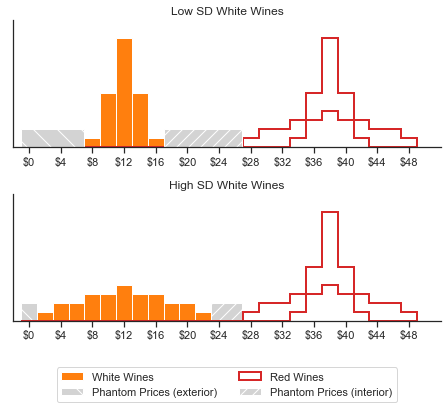

In [4]:
plot_phantom_range(show=True, save=True)
plot_phantom_range(show=False, save=True, grayscale=True)

## Distributions by condition

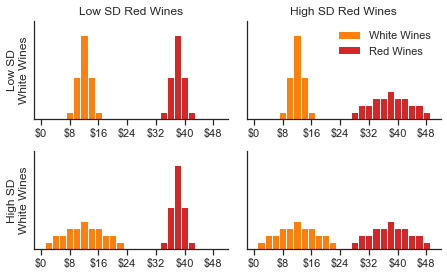

In [5]:
plot_design(show=True, save=True)
plot_design(show=False, save=True, grayscale=True)

## Number of valid participants

In [6]:
df_agg.pid.unique().shape[0]

301

# Analysis

## SD of prices

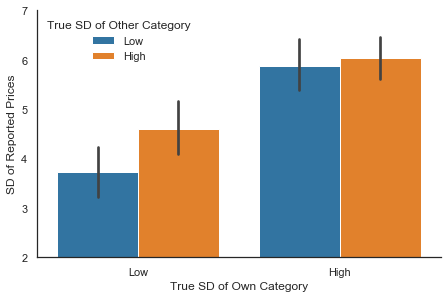

In [7]:
plot_results(df_agg, show=False, save=True, grayscale=True)
plot_results(df_agg, show=True, save=True)

In [8]:
model = smf.mixedlm(
    "value_sd~C(sd_focal, Diff, levels=['Low', 'High'])\
*C(sd_other, Diff, levels=['Low', 'High'])",
    data=df_agg,
    groups=df_agg.turkid,
).fit()
model.summary(
    xname_fe=[
        "Intercept",
        "Own: High vs. Low SD",
        "Other: High vs. Low SD",
        "Interaction",
    ],
    yname="SD of Prices",
    xname_re=["Participant Random Effects"],
)

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:                 MixedLM    Dependent Variable:    SD of Prices
No. Observations:      602        Method:                REML        
No. Groups:            301        Scale:                 6.3389      
Min. group size:       2          Log-Likelihood:        -1527.8033  
Max. group size:       2          Converged:             Yes         
Mean group size:       2.0                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   5.061    0.152 33.278 0.000  4.762  5.359
Own: High vs. Low SD        1.792    0.258  6.944 0.000  1.286  2.298
Other: High vs. Low SD      0.516    0.258  1.999 0.046  0.010  1.021
Interaction                -0.737    0.608 -1.211 0.226 -1.929  0.456
Participant Random Effects  3.785    0.319                           
=====================================================================

"""

In [9]:
stdbetas = model.params[:-1] / df_agg.value_sd.std(ddof=1)
stdbetas.index = [
    "Intercept",
    "Own: High vs. Low SD",
    "Other: High vs. Low SD",
    "Interaction",
]
table = pd.DataFrame(stdbetas, columns=["Standardized Betas"])
table.style.format("{:.2f}")

,Standardized Betas
Intercept,1.53
Own: High vs. Low SD,0.54
Other: High vs. Low SD,0.16
Interaction,-0.22


## Analysis of the phantom prices

### All phantom prices

In [10]:
model = smf.mixedlm(
    "phantom_total~C(sd_focal, Treatment(1))*C(sd_other, Treatment(1))",
    data=df_agg,
    groups=df_agg.turkid,
).fit()
model.summary(
    yname="Phantom Prices (All)",
    xname_fe=[
        "Intercept",
        "Own: High vs. Low SD",
        "Other: High vs. Low SD",
        "Interaction",
    ],
    xname_re=["Participant Random Effects"],
)

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:             MixedLM  Dependent Variable:  Phantom Prices (All)
No. Observations:  602      Method:              REML                
No. Groups:        301      Scale:               11.8808             
Min. group size:   2        Log-Likelihood:      -1651.7701          
Max. group size:   2        Converged:           Yes                 
Mean group size:   2.0                                               
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   4.109    0.330 12.454 0.000  3.462  4.756
Own: High vs. Low SD       -2.376    0.456 -5.214 0.000 -3.269 -1.483
Other: High vs. Low SD      1.980    0.456  4.345 0.000  1.087  2.873
Interaction                -1.531    0.672 -2.278 0.023 -2.848 -0.214
Participant Random Effects  2.550    0.285                           
=====================================================================

"""

In [11]:
stdbetas = model.params[:-1] / df_agg.phantom_total.std(ddof=1)
stdbetas.index = [
    "Intercept",
    "Given: High vs. Low",
    "Other: High vs. Low",
    "Interaction",
]
table = pd.DataFrame(stdbetas, columns=["Standardized Betas"])
table.style.format("{:.2f}")

,Standardized Betas
Intercept,0.99
Given: High vs. Low,-0.57
Other: High vs. Low,0.48
Interaction,-0.37


### Out-range only

In [12]:
model = smf.mixedlm(
    "phantom_outside~C(sd_focal, Treatment(1))*C(sd_other, Treatment(1))",
    data=df_agg,
    groups=df_agg.turkid,
).fit()
model.summary(
    yname="Phantom Prices (Exterior Only)",
    xname_fe=[
        "Intercept",
        "Own: High vs. Low SD",
        "Other: High vs. Low SD",
        "Interaction",
    ],
    xname_re=["Participant Random Effects"],
)

C:\Users\Quentin ANDRE\.conda\envs\researchshared\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
============================================================================
Model:            MixedLM Dependent Variable: Phantom Prices (Exterior Only)
No. Observations: 602     Method:             REML                          
No. Groups:       301     Scale:              3.1377                        
Min. group size:  2       Log-Likelihood:     -1200.4531                    
Max. group size:  2       Converged:          Yes                           
Mean group size:  2.0                                                       
-----------------------------------------------------------------------------
                              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------------------
Intercept                      0.801     0.142   5.650  0.000   0.523   1.079
Own: High vs. Low SD          -0.431     0.204  -2.115  0.034  -0.831  -0.032
Other: High vs. Low SD         0.445     0.204   2.183  0.029   0.046   0.845
Interaction                   -0.348     0.289  -1.203  0.229  -0.914   0.219
Participant Random Effects     0.000     0.114                               
============================================================================

"""

In [13]:
stdbetas = model.params[:-1] / df_agg.phantom_outside.std(ddof=1)
stdbetas.index = [
    "Intercept",
    "Given: High vs. Low",
    "Other: High vs. Low",
    "Interaction",
]
table = pd.DataFrame(stdbetas, columns=["Standardized Betas"])
table.style.format("{:.2f}")

,Standardized Betas
Intercept,0.45
Given: High vs. Low,-0.24
Other: High vs. Low,0.25
Interaction,-0.19
